## MTH9899 Machine Learning 
### Assignment 1
#### Name: ShengQuan Zhou

### Problem 1

In class, we spoke about the time complexity for multiplying matrices. Ignoring
more sophisticated algorithms, like the Strassen algorithm, multiplying an $a \times b$ matrix
by a $b \times c$ matrix takes $O(abc)$. As we did in class, please work out the time complexity
of computing a naive $K$-Fold Cross Validation Ridge Regression on an $N \times F$ input
matrix.

#### Solution:

The estimate of Ridge regression reads
$$
\hat{y} = X\left( X^TX + \lambda\mathbb{1} \right)^{-1}X^T y,
$$
where $X$ is an $N\times F$ input matrix, $y$ is the $N\times 1$ output vector, and $\hat{y}$ is the $N\times 1$ estimated output vector.

For a $K$-fold cross validation, the rows of the input matrix $X$ is divided into $K$ chunks, each chunk has size $\frac{N}{K}$ rows and $F$ columns. Removing each chunk from the input matrix, the training input matrix $X'$ has $N(1-\frac{1}{K})$ rows and $F$ columns. Computing the estimated output $
\hat{y}' = X'\left( X'^TX' + \lambda\mathbb{1} \right)^{-1}X'^T y'$ takes a few steps:

- computing $X'^T y'$ takes $FN(1-\frac{1}{K})$ operations, resulting in a vector of size $F$;
- computing $X'^TX' + \lambda\mathbb{1}$ takes $F^2 N(1-\frac{1}{K}) + F$ operations, resulting in a matrix of size $F\times F$;
- computing $\left( X'^TX' + \lambda\mathbb{1} \right)^{-1}X'^T y'$ requires solving a symmetric positive-definite linear system and takes roughly $\frac{1}{3}F^3 + \frac{5}{2}F^2 + O(F)$, according to NLA Primer, resulting in a vector of size $F$;
- computing $X'\left( X'^TX' + \lambda\mathbb{1} \right)^{-1}X'^T y'$ takes $FN(1-\frac{1}{K})$ operations, resulting in a vector of size $N(1-\frac{1}{K})$.

Adding all the above steps together, we get $F^2 N (1-\frac{1}{K}) + 2FN (1-\frac{1}{K}) + \frac{1}{3}F^3 + \frac{5}{2}F^2 + O(F)$ for each Ridge regression. Performing the above Ridge regression $K$ times, we get an operation count
$$
F^2 N (K-1) + 2FN (K-1) + \frac{1}{3}F^3K + \frac{5}{2}F^2K + O(F\times K).
$$
As $N\gg 1$, the terms of leading order are $(K-1)(F^2+F)N$.

### Problem 2

We can be more efficient. In particular, we don’t have to compute $(X^TX)^{-1}$ completely each time. In particular, if you break up $X$ into $K$ chunks, there is a faster way.
$$
X = \begin{bmatrix}
X_1\\
X_2\\
\vdots\\
X_K
\end{bmatrix},
$$
then
$$
X^T X = \begin{bmatrix}
X_1^T\ 
X_2^T\ 
\cdots X_K^T\ 
\end{bmatrix}\times \begin{bmatrix}
X_1\\
X_2\\
\vdots\\
X_K
\end{bmatrix}
= \sum _ {i=1}^K X_i^TX_i.
$$
Define $X _ {-i}$ as $X$ with the ith fold omitted. Given these hints, write a description
of how you can efficiently compute $X _ {−i}^TX _ {−i}$ for all $K$ folds.

#### Solution:

Each $X_i$ is a matrix of $\frac{N}{K}$ rows and $F$ columns. One can compute the matrix terms $X_i^TX_i, i=1,\cdots,K$ separately, each taking $F^2\frac{N}{K}$ operations and resulting in an $F\times F$ matrix. Thus, computing $X^TX$ takes $F^2 N+\frac{1}{2}F^2(K-1)$ operations in total, where the latter term $\frac{1}{2}F^2(K-1)$ comes from adding $K$ number of $F\times F$ symmetric matrices together.

We can gain some efficiency by saving the matrix terms $X_k^TX_k, k=1,\cdots,K$. One can then compute $X _ {−i}^TX _ {−i}$ by subtracting $X _ {i}^TX _ {i}$ from $\sum _ {j=1}^K X_j^TX_j$, which each takes $\frac{1}{2}F^2$. Again, the approximate factor $\frac{1}{2}$ comes from the fact that all matrices involved are symmetric. Using this approach, the total operation count is
$$
F^2 N + 2FN(K-1) + \frac{1}{3}F^3 K + \frac{1}{2}F^2(7K-1) + O(FK).
$$
As $N\gg 1$, the terms of leading order are $(F^2  + 2F(K-1))N$.

To compare with the naive $K$-fold cross validation discussed in the previous problem, we consider the case $K\gg 1$, the leading terms
- Naive implementation: $K(F^2+F)N\sim O(F^2 K N) + O(FKN)$;
- Efficient implementation: $\sim (F^2  + 2FK)N \sim O(F^2 N) + O(FKN)$.

A difference of factor $K$ is observed in the leading term proportional to $F^2N$.

### Problem 3

In [1]:
import numpy as np
import time

In [2]:
naive_total_timing_results = {}
fast_total_timing_results = {}
naive_partial_timing_results = {}
fast_partial_timing_results = {}

def timeit(method):
    """ A timing decorator """

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        
        nrows = np.size(args[0], 0)
        ncols = np.size(args[0], 1)
        F_N_tuple = (ncols, nrows)
        
        print(method.__name__, ":", "%.6f" % (te-ts), ' sec')
        
        if method.__name__ == "naive_compute_XTX_XTY":
            naive_partial_timing_results[F_N_tuple] = (te-ts)
        elif method.__name__ == "fast_compute_XTX_XTY":
            fast_partial_timing_results[F_N_tuple] = (te-ts)
        elif method.__name__ == "naive_ridge_cv":
            naive_total_timing_results[F_N_tuple] = (te-ts)
        elif method.__name__ == "fast_ridge_cv":
            fast_total_timing_results[F_N_tuple] = (te-ts)
        
        return result

    return timed

In [3]:
def generate_test_data(n,f):
    np.random.seed(1)
    true_betas = np.random.randn(f)
    
    X = np.random.randn(n,f)
    Y = np.random.randn(n) + X.dot(true_betas)
    
    return (X,Y)

In [4]:
@timeit
def ridge_cv_helper(X, Y, XTX_train_list, XTY_train_list, num_folds, lambdas):
    """ A helper function for Ridge regression of X against Y. 
        It will take in a list of suggested lambda values, the prepared
        list of matrices XTX and vectors XTY over the training sets and 
        return back the lambda. This is a common code used by both
        the naive version and the fast version of ridge cross-validation.
        
        Parameters
        ----------
        X : numpy ndarray
            The independent variables, structured as (samples x features)
        Y : numpy ndarray
            The dependent variable (samples x 1)
        XTX_train_list: list of numpy ndarray
            The matrix-matrix products of X-transpose and X over the training sets
        XTY_train_list: list of numpy ndarray
            The matrix-vecotr products of X-transpose and Y over the training sets
        num_folds : int
            The number of folds to use for cross validation
        lambdas : numpy ndarray
            An array of lambda values to test
           
        Returns
        -------
        lambda_star : float
                The lambda value that represents the min MSE
        """
    
    num_rows = np.size(X,0)
    num_cols = np.size(X,1)
    chunk_size = int(num_rows/num_folds)
    
    min_error_initialized = False
    min_error = 0
    optimal_lambda = 0
    for Lambda in lambdas:
        total_error = 0
        for i in range(num_folds):
            XTX_train = XTX_train_list[i]
            XTY_train = XTY_train_list[i]
            beta = np.linalg.solve(XTX_train+Lambda*np.identity(num_cols), XTY_train)
            X_test = X[i*chunk_size : (i+1)*chunk_size]
            Y_test = Y[i*chunk_size : (i+1)*chunk_size]
            Y_estimated = X_test.dot(beta)
            error = np.linalg.norm(Y_estimated-Y_test)
            error *= error
            total_error += error
            
        # find the lambda for minimum MSE
        if not min_error_initialized:
            min_error = total_error
            optimal_lambda = Lambda
            min_error_initialized = True
        else:
            if total_error < min_error:
                min_error = total_error
                optimal_lambda = Lambda
        
    return optimal_lambda

In [5]:
@timeit
def naive_compute_XTX_XTY(X, Y, num_folds):
    """ A helper function for Ridge regression of X against Y. 
        This is the naive way to compute XTX and XTY over the training set.
        It will take in the input matrix and the output vector and
        return the list of matrices XTX and vectors XTY over the training sets.
        This will be called in naive_ridge_cv.
        
        Parameters
        ----------
        X : numpy ndarray
            The independent variables, structured as (samples x features)
        Y : numpy ndarray
            The dependent variable (samples x 1)
        num_folds : int
            The number of folds to use for cross validation
           
        Returns
        -------
        XTX_train_list: list of numpy ndarray
            The matrix-matrix products of X-transpose and X over the training sets
        XTY_train_list: list of numpy ndarray
            The matrix-vecotr products of X-transpose and Y over the training sets
        """
    
    num_rows = np.size(X,0)
    chunk_size = int(num_rows/num_folds)
    
    XTY_train_list = []
    XTX_train_list = []
    for i in range(num_folds):
        X_train = np.delete(X, np.s_[i*chunk_size : (i+1)*chunk_size], 0)
        Y_train = np.delete(Y, np.s_[i*chunk_size : (i+1)*chunk_size], 0)
        XTY_train = (X_train.T).dot(Y_train)
        XTX_train = (X_train.T).dot(X_train)
        XTY_train_list.append(XTY_train)
        XTX_train_list.append(XTX_train)
        
    return (XTX_train_list, XTY_train_list)

In [6]:
@timeit
def fast_compute_XTX_XTY(X, Y, num_folds):
    """ A helper function for Ridge regression of X against Y. 
        This is the fast way to compute XTX and XTY over the training set.
        It will take in the input matrix and the output vector and
        return the list of matrices XTX and vectors XTY over the training sets.
        It will also return the matrix XTX and the vector XTY over the complete set.
        This will be called in fast_ridge_cv.
        
        Parameters
        ----------
        X : numpy ndarray
            The independent variables, structured as (samples x features)
        Y : numpy ndarray
            The dependent variable (samples x 1)
        num_folds : int
            The number of folds to use for cross validation
           
        Returns
        -------
        XTX: numpy ndarray
            The matrix-matrix products of X-transpose and X
        XTY: numpy ndarray
             The matrix-vecotr products of X-transpose and Y
        XTX_train_list: list of numpy ndarray
            The matrix-matrix products of X-transpose and X over the training sets
        XTY_train_list: list of numpy ndarray
            The matrix-vecotr products of X-transpose and Y over the training sets
        """
    
    num_rows = np.size(X,0)
    chunk_size = int(num_rows/num_folds)
    
    XTY = (X.T).dot(Y)
    XTX = (X.T).dot(X)
    
    # Save a copy of X.T.X and X.T.Y to avoid duplicated computation for each lambda
    XTY_train_list = []
    XTX_train_list = []
    for i in range(num_folds):
        # The fast way to compute XTX and XTY over the training set
        X_test = X[i*chunk_size : (i+1)*chunk_size]
        Y_test = Y[i*chunk_size : (i+1)*chunk_size]
        XTY_test = (X_test.T).dot(Y_test)
        XTX_test = (X_test.T).dot(X_test)
        XTY_train = XTY - XTY_test
        XTX_train = XTX - XTX_test
        XTY_train_list.append(XTY_train)
        XTX_train_list.append(XTX_train)
        
    return (XTX, XTY, XTX_train_list, XTY_train_list)

In [7]:
@timeit
def naive_ridge_cv(X, Y, num_folds, lambdas):
    """ Implements a naive (i.e. slow) Ridge regression of X against Y. 
        It will take in a list of suggested lambda values and return back
        the lambda and betas that generates minimum squared error.
        
        Parameters
        ----------
        X : numpy ndarray
            The independent variables, structured as (samples x features)
        Y : numpy ndarray
            The dependent variable (samples x 1)
        num_folds : int
            The number of folds to use for cross validation
        lambdas : numpy ndarray
            An array of lambda values to test
           
        Returns
        -------
        lambda_star : float
                The lambda value that represents the min MSE
        beta_star : numpy ndarray
                The optimal betas
        """

    # Save a copy of X.T.X and X.T.Y to avoid duplicated computation for each lambda
    (XTX_train_list, XTY_train_list) = naive_compute_XTX_XTY(X, Y, num_folds)
        
    # look for each lambda value
    optimal_lambda = ridge_cv_helper(X, Y, XTX_train_list, XTY_train_list, num_folds, lambdas)
                
    # compute the optimal betas using the complete input
    XTY = (X.T).dot(Y)
    XTX = (X.T).dot(X)
    
    num_cols = np.size(X,1)
    optimal_beta = np.linalg.solve(XTX+optimal_lambda*np.identity(num_cols), XTY)
    
    return (optimal_lambda, optimal_beta)

In [8]:
@timeit
def fast_ridge_cv(X, Y, num_folds, lambdas):
    """ Implements a fast Ridge regression of X against Y. 
        It will take in a list of suggested lambda values and return back
        the lambda and betas that generates minimum squared error.
        
        Parameters
        ----------
        X : numpy ndarray
            The independent variables, structured as (samples x features)
        Y : numpy ndarray
            The dependent variable (samples x 1)
        num_folds : int
            The number of folds to use for cross validation
        lambdas : numpy ndarray
            An array of lambda values to test
           
        Returns
        -------
        lambda_star : float
                The lambda value that represents the min MSE
        beta_star : numpy ndarray
                The optimal betas
        """
    
    num_rows = np.size(X,0)
    num_cols = np.size(X,1)
    chunk_size = int(num_rows/num_folds)
    
    # Save a copy of X.T.X and X.T.Y to avoid duplicated computation for each lambda
    (XTX, XTY, XTX_train_list, XTY_train_list) = fast_compute_XTX_XTY(X, Y, num_folds)
        
    # look for each lambda value
    optimal_lambda = ridge_cv_helper(X, Y, XTX_train_list, XTY_train_list, num_folds, lambdas)
                
    # compute the optimal betas using the complete input
    optimal_beta = np.linalg.solve(XTX+optimal_lambda*np.identity(num_cols), XTY)
        
    return (optimal_lambda, optimal_beta)

In [9]:
num_folds = 10
N_list = [1000, 10000, 100000, 1000000]
F_list = [5, 50]
min_lambda = 0
max_lambda = 3
num_lambdas = 10
Lambda_list = np.arange(min_lambda, max_lambda, (max_lambda-min_lambda)/num_lambdas)

print("Naive way:")
print("~~~~~~")
# number of columns, or features
for F in F_list:
    # number of rows, or observations
    for N in N_list:
        print("F =", F, ", N =", N)
        print("------")
        (X,Y) = generate_test_data(N,F)
        (optimal_lambda, optimal_beta) = naive_ridge_cv(X, Y, num_folds, Lambda_list)
        print("------")
        print("Optimal lambda = ", np.round(optimal_lambda, 3)) 
        print("======")
        
print("Fast way:")
print("~~~~~~")
# number of columns, or features
for F in F_list:
    # number of rows, or observations
    for N in N_list:
        print("F =", F, ", N =", N)
        print("------")
        (X,Y) = generate_test_data(N,F)
        (optimal_lambda, optimal_beta) = fast_ridge_cv(X, Y, num_folds, Lambda_list)
        print("------")
        print("Optimal lambda = ", np.round(optimal_lambda, 3))
        print("======")

Naive way:
~~~~~~
F = 5 , N = 1000
------
naive_compute_XTX_XTY : 0.002746  sec
ridge_cv_helper : 0.013362  sec
naive_ridge_cv : 0.017086  sec
------
Optimal lambda =  1.2
F = 5 , N = 10000
------
naive_compute_XTX_XTY : 0.002158  sec
ridge_cv_helper : 0.006608  sec
naive_ridge_cv : 0.010121  sec
------
Optimal lambda =  0.9
F = 5 , N = 100000
------
naive_compute_XTX_XTY : 0.024142  sec
ridge_cv_helper : 0.010868  sec
naive_ridge_cv : 0.037698  sec
------
Optimal lambda =  1.2
F = 5 , N = 1000000
------
naive_compute_XTX_XTY : 0.273132  sec
ridge_cv_helper : 0.069072  sec
naive_ridge_cv : 0.359189  sec
------
Optimal lambda =  0.6
F = 50 , N = 1000
------
naive_compute_XTX_XTY : 0.002565  sec
ridge_cv_helper : 0.016575  sec
naive_ridge_cv : 0.020505  sec
------
Optimal lambda =  1.2
F = 50 , N = 10000
------
naive_compute_XTX_XTY : 0.025449  sec
ridge_cv_helper : 0.014203  sec
naive_ridge_cv : 0.042597  sec
------
Optimal lambda =  0.9
F = 50 , N = 100000
------
naive_compute_XTX_XTY 

### Results

#### The partial time consumed by computing the products of partial matrices over the training set.

In [28]:
naive_XTX_time_F_5 = [naive_partial_timing_results[(5, 1000)],
                      naive_partial_timing_results[(5, 10000)],
                      naive_partial_timing_results[(5, 100000)],
                      naive_partial_timing_results[(5, 1000000)]]

fast_XTX_time_F_5 = [fast_partial_timing_results[(5, 1000)],
                     fast_partial_timing_results[(5, 10000)],
                     fast_partial_timing_results[(5, 100000)],
                     fast_partial_timing_results[(5, 1000000)]]

naive_XTX_time_F_50 = [naive_partial_timing_results[(50, 1000)],
                       naive_partial_timing_results[(50, 10000)],
                       naive_partial_timing_results[(50, 100000)],
                       naive_partial_timing_results[(50, 1000000)]]

fast_XTX_time_F_50 = [fast_partial_timing_results[(50, 1000)],
                      fast_partial_timing_results[(50, 10000)],
                      fast_partial_timing_results[(50, 100000)],
                      fast_partial_timing_results[(50, 1000000)]]        

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline  

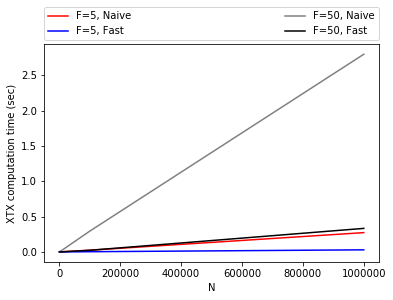

In [38]:
plt.ylabel('XTX computation time (sec)')
plt.xlabel('N')
plt.plot(N_list, naive_XTX_time_F_5, label='F=5, Naive', color='red')
plt.plot(N_list, fast_XTX_time_F_5, label='F=5, Fast', color='blue')
plt.plot(N_list, naive_XTX_time_F_50, label='F=50, Naive', color='gray')
plt.plot(N_list, fast_XTX_time_F_50, label='F=50, Fast', color='black')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

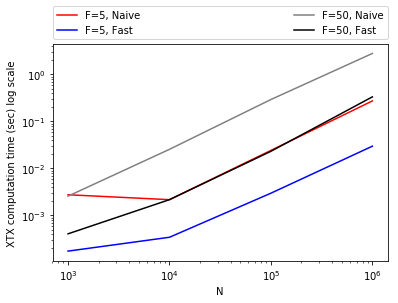

In [39]:
plt.xscale('log')
plt.yscale('log')
plt.ylabel('XTX computation time (sec) log scale')
plt.xlabel('N')
plt.plot(N_list, naive_XTX_time_F_5, label='F=5, Naive', color='red')
plt.plot(N_list, fast_XTX_time_F_5, label='F=5, Fast', color='blue')
plt.plot(N_list, naive_XTX_time_F_50, label='F=50, Naive', color='gray')
plt.plot(N_list, fast_XTX_time_F_50, label='F=50, Fast', color='black')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

#### The total time of performing Ridge regression cross validation.

In [44]:
naive_total_time_F_5 = [naive_total_timing_results[(5, 1000)],
                        naive_total_timing_results[(5, 10000)],
                        naive_total_timing_results[(5, 100000)],
                        naive_total_timing_results[(5, 1000000)]]

fast_total_time_F_5 = [fast_total_timing_results[(5, 1000)],
                       fast_total_timing_results[(5, 10000)],
                       fast_total_timing_results[(5, 100000)],
                       fast_total_timing_results[(5, 1000000)]]

naive_total_time_F_50 = [naive_total_timing_results[(50, 1000)],
                         naive_total_timing_results[(50, 10000)],
                         naive_total_timing_results[(50, 100000)],
                         naive_total_timing_results[(50, 1000000)]]

fast_total_time_F_50 = [fast_total_timing_results[(50, 1000)],
                        fast_total_timing_results[(50, 10000)],
                        fast_total_timing_results[(50, 100000)],
                        fast_total_timing_results[(50, 1000000)]] 

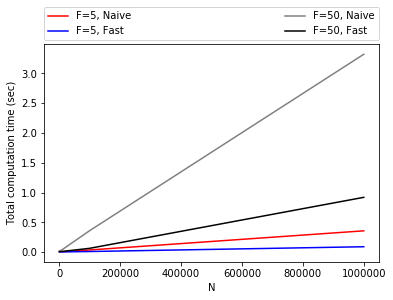

In [46]:
plt.ylabel('Total computation time (sec)')
plt.xlabel('N')
plt.plot(N_list, naive_total_time_F_5, label='F=5, Naive', color='red')
plt.plot(N_list, fast_total_time_F_5, label='F=5, Fast', color='blue')
plt.plot(N_list, naive_total_time_F_50, label='F=50, Naive', color='gray')
plt.plot(N_list, fast_total_time_F_50, label='F=50, Fast', color='black')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

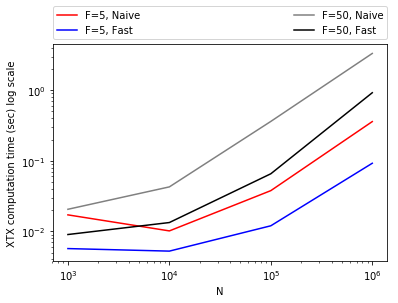

In [47]:
plt.xscale('log')
plt.yscale('log')
plt.ylabel('XTX computation time (sec) log scale')
plt.xlabel('N')
plt.plot(N_list, naive_total_time_F_5, label='F=5, Naive', color='red')
plt.plot(N_list, fast_total_time_F_5, label='F=5, Fast', color='blue')
plt.plot(N_list, naive_total_time_F_50, label='F=50, Naive', color='gray')
plt.plot(N_list, fast_total_time_F_50, label='F=50, Fast', color='black')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

The numerical results showing the linear relationship between the computing time and the number of observations $N$, with slopes depending on the number of features $F$, agree with the theoretical estimate.